In [42]:
import pandas as pd
import re
import joblib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

print("✅ Các thư viện đã được import thành công.")

✅ Các thư viện đã được import thành công.


In [44]:
# ==============================================================================
# CELL 2: ĐỊNH NGHĨA CÁC HÀM TIỀN XỬ LÝ DỮ LIỆU
# ==============================================================================

def preprocess_dataset_A_full(file_path: str) -> pd.DataFrame:
    """
    Hàm này xử lý file Excel của Dataset A.
    1. Lấy và đổi tên các cột thông tin cá nhân.
    2. Tạo tên cột ngữ cảnh cho các câu hỏi tâm lý.
    3. Kết hợp cả hai thành một DataFrame hoàn chỉnh.
    """
    try:
        data_df = pd.read_excel(file_path, sheet_name='Data', header=0) 
        codes_df = pd.read_excel(file_path, sheet_name='Questionnaires and Codes')
        print(f"Đã đọc thành công file: {file_path}")

        demographic_rename_map = {'c1': 'School', 'c2': 'Gender', 'c3': 'YOB', 'c4': 'GPA'}
        demographic_df = data_df[list(demographic_rename_map.keys())].rename(columns=demographic_rename_map)
        print(f"  -> Đã xử lý {demographic_df.shape[1]} cột thông tin cá nhân.")

        code_mapper = {}
        current_group_prefix = ""
        codes_df['question_key'] = codes_df['Questions'].str.extract(r'^(\d+\.\d+)\s')
        
        for index, row in codes_df.iterrows():
            question_key = str(row['question_key'])
            code = str(row['Code'])
            is_group_header = pd.isna(row['question_key']) and pd.notna(code)

            if is_group_header and code not in ['School', 'Gender', 'YOB', 'GPA']:
                current_group_prefix = code
            elif pd.notna(row['question_key']) and pd.notna(code) and current_group_prefix:
                contextual_code = f"{current_group_prefix}_{code}"
                code_mapper[question_key] = contextual_code

        psychological_rename_mapper = {}
        for col_name in data_df.columns:
            match = re.match(r'c(\d+)x(\d+)', str(col_name))
            if match:
                question_number_str = f"{match.group(1)}.{match.group(2)}"
                if question_number_str in code_mapper:
                    psychological_rename_mapper[col_name] = code_mapper[question_number_str]

        data_df_renamed = data_df.rename(columns=psychological_rename_mapper)
        psychological_columns = list(psychological_rename_mapper.values())
        psychological_df = data_df_renamed[psychological_columns]
        print(f"  -> Đã xử lý {psychological_df.shape[1]} cột dữ liệu tâm lý.")

        final_df = pd.concat([demographic_df, psychological_df], axis=1)
        print(f"  -> Kết hợp thành công! DataFrame cuối cùng có {final_df.shape[1]} cột.")
        return final_df
    except Exception as e:
        print(f"Đã xảy ra lỗi khi xử lý file {file_path}: {e}")
        return None

def preprocess_dataset_B_final(file_path: str) -> pd.DataFrame:
    """
    Hàm này xử lý file Excel của Dataset B.
    Nó sử dụng phương pháp forward-fill để xác định nhóm cho mỗi câu hỏi
    và tạo ra tên cột ngữ cảnh một cách đáng tin cậy.
    """
    try:
        data_df = pd.read_excel(file_path, sheet_name='Responses', header=0) 
        codes_df = pd.read_excel(file_path, sheet_name='Questions and Codes')
        print(f"Đã đọc thành công file: {file_path}")

        demographic_data_df = data_df.iloc[:, 0:12]
        demographic_codes = codes_df.iloc[0:12]['Code'].dropna().tolist()
        demographic_data_df.columns = demographic_codes
        print(f"  -> Đã xử lý {demographic_data_df.shape[1]} cột thông tin cá nhân.")

        start_data_col_index = 12
        psychological_data_df = data_df.iloc[:, start_data_col_index:]
        num_data_columns = psychological_data_df.shape[1]
        
        psychological_codes_df = codes_df.iloc[13:].copy()
        psychological_codes_df['group'] = psychological_codes_df.where(pd.isna(psychological_codes_df['No.']))['Code']
        psychological_codes_df['group'] = psychological_codes_df['group'].ffill()
        psychological_codes_df = psychological_codes_df.dropna(subset=['No.'])
        
        psychological_codes_df['group'] = psychological_codes_df['group'].astype(str)
        psychological_codes_df['Code'] = psychological_codes_df['Code'].astype(str)

        all_possible_codes = (psychological_codes_df['group'] + '_' + psychological_codes_df['Code']).tolist()
        psychological_codes_list = all_possible_codes[:num_data_columns]
        num_psychological_questions = len(psychological_codes_list)
        
        print(f"  -> Đã tìm thấy {num_data_columns} cột dữ liệu tâm lý.")
        print(f"  -> Đã tạo {num_psychological_questions} mã code ngữ cảnh tương ứng.")
        
        if num_data_columns != num_psychological_questions:
            raise ValueError(f"Số cột không khớp: {num_data_columns} != {num_psychological_questions}")

        psychological_data_df.columns = psychological_codes_list
        
        psychological_data_df.index = demographic_data_df.index
        final_df = pd.concat([demographic_data_df, psychological_data_df], axis=1)
        
        print(f"  -> Kết hợp thành công! DataFrame cuối cùng có {final_df.shape[1]} cột.")
        return final_df
    except Exception as e:
        print(f"Đã xảy ra lỗi khi xử lý file {file_path}: {e}")
        return None
        
print("✅ Các hàm tiền xử lý đã được định nghĩa.")

✅ Các hàm tiền xử lý đã được định nghĩa.


In [45]:
# ==============================================================================
# CELL 3: TẢI, TIỀN XỬ LÝ VÀ LÀM SẠCH DỮ LIỆU
# ==============================================================================

# --- Tải và tiền xử lý ---
file_a = "data/student_data/Student-Academic-Perfectionism-1.xlsx" 
file_b = "data/student_data/Survey on Vietnamese Students' School Alienation, Academic Contingent Self-worth and Parents' and Teachers' Academic Conditional Regard.xlsx" 

data_a = preprocess_dataset_A_full(file_a)
data_b = preprocess_dataset_B_final(file_b)

# --- Xử lý giá trị thiếu (Missing Values) ---
if data_a is not None and data_b is not None:
    print("\nKiểm tra giá trị thiếu trước khi xử lý:")
    print("Dataset A:", data_a.isnull().sum().sum(), "ô bị thiếu")
    print("Dataset B:", data_b.isnull().sum().sum(), "ô bị thiếu")

    # Điền các giá trị thiếu bằng giá trị trung vị (median) của cột đó.
    data_a = data_a.fillna(data_a.median(numeric_only=True))
    data_b = data_b.fillna(data_b.median(numeric_only=True))

    print("\nKiểm tra giá trị thiếu sau khi xử lý:")
    print("Dataset A:", data_a.isnull().sum().sum(), "ô bị thiếu")
    print("Dataset B:", data_b.isnull().sum().sum(), "ô bị thiếu")
    print("\n✅ Dữ liệu đã sạch và sẵn sàng để phân tích.")
else:
    print("\n⚠️  Có lỗi xảy ra trong quá trình tiền xử lý, vui lòng kiểm tra lại.")

Đã đọc thành công file: data/student_data/Student-Academic-Perfectionism-1.xlsx
  -> Đã xử lý 4 cột thông tin cá nhân.
  -> Đã xử lý 46 cột dữ liệu tâm lý.
  -> Kết hợp thành công! DataFrame cuối cùng có 50 cột.
Đã đọc thành công file: data/student_data/Survey on Vietnamese Students' School Alienation, Academic Contingent Self-worth and Parents' and Teachers' Academic Conditional Regard.xlsx
  -> Đã xử lý 12 cột thông tin cá nhân.
  -> Đã tìm thấy 50 cột dữ liệu tâm lý.
  -> Đã tạo 50 mã code ngữ cảnh tương ứng.
  -> Kết hợp thành công! DataFrame cuối cùng có 62 cột.

Kiểm tra giá trị thiếu trước khi xử lý:
Dataset A: 0 ô bị thiếu
Dataset B: 0 ô bị thiếu

Kiểm tra giá trị thiếu sau khi xử lý:
Dataset A: 0 ô bị thiếu
Dataset B: 0 ô bị thiếu

✅ Dữ liệu đã sạch và sẵn sàng để phân tích.


C:\Users\Hi\AppData\Local\Temp\ipykernel_11464\2926773627.py:78: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  psychological_codes_df['group'] = psychological_codes_df['group'].ffill()


✅ Dữ liệu tâm lý đã được tách và chuẩn hóa.

--- Đang tìm số cụm tối ưu cho Dataset A (Động lực) ---
Với k=2, Silhouette Score là: 0.4006
Với k=3, Silhouette Score là: 0.1780
Với k=4, Silhouette Score là: 0.1595
Với k=5, Silhouette Score là: 0.1393
Với k=6, Silhouette Score là: 0.1203
Với k=7, Silhouette Score là: 0.1125
Với k=8, Silhouette Score là: 0.0706
Với k=9, Silhouette Score là: 0.0645
Với k=10, Silhouette Score là: 0.0570


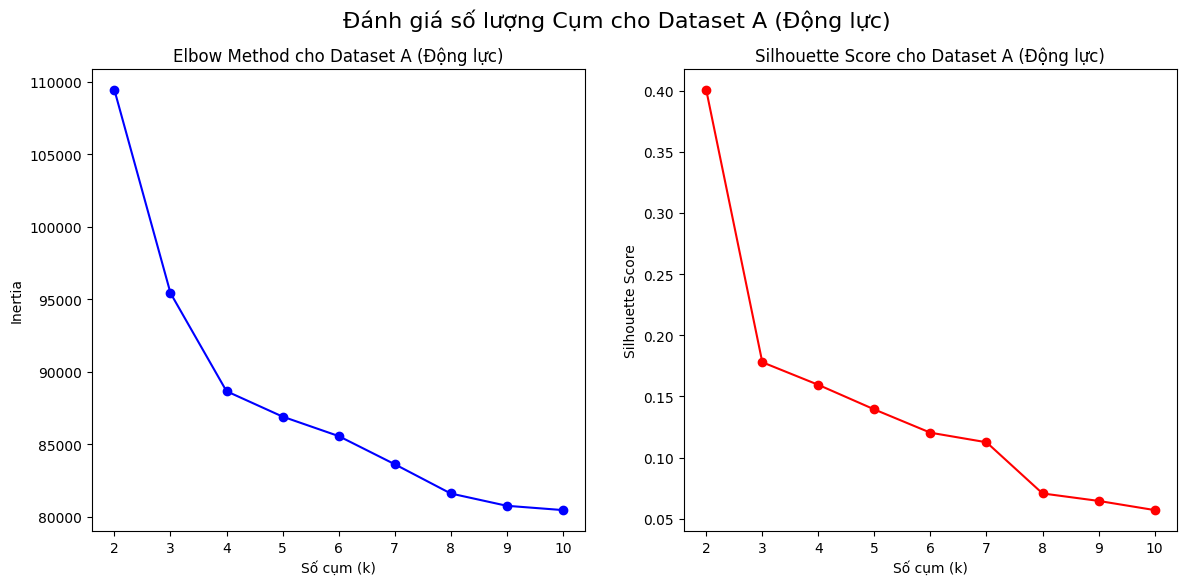

==> Dựa trên Silhouette Score, số cụm tối ưu cho Dataset A (Động lực) là: k = 2

--- Đang tìm số cụm tối ưu cho Dataset B (Gắn kết) ---
Với k=2, Silhouette Score là: 0.1266
Với k=3, Silhouette Score là: -0.0030
Với k=4, Silhouette Score là: -0.0001
Với k=5, Silhouette Score là: -0.0003
Với k=6, Silhouette Score là: -0.0001
Với k=7, Silhouette Score là: -0.0015
Với k=8, Silhouette Score là: -0.0061
Với k=9, Silhouette Score là: -0.0078
Với k=10, Silhouette Score là: -0.0044


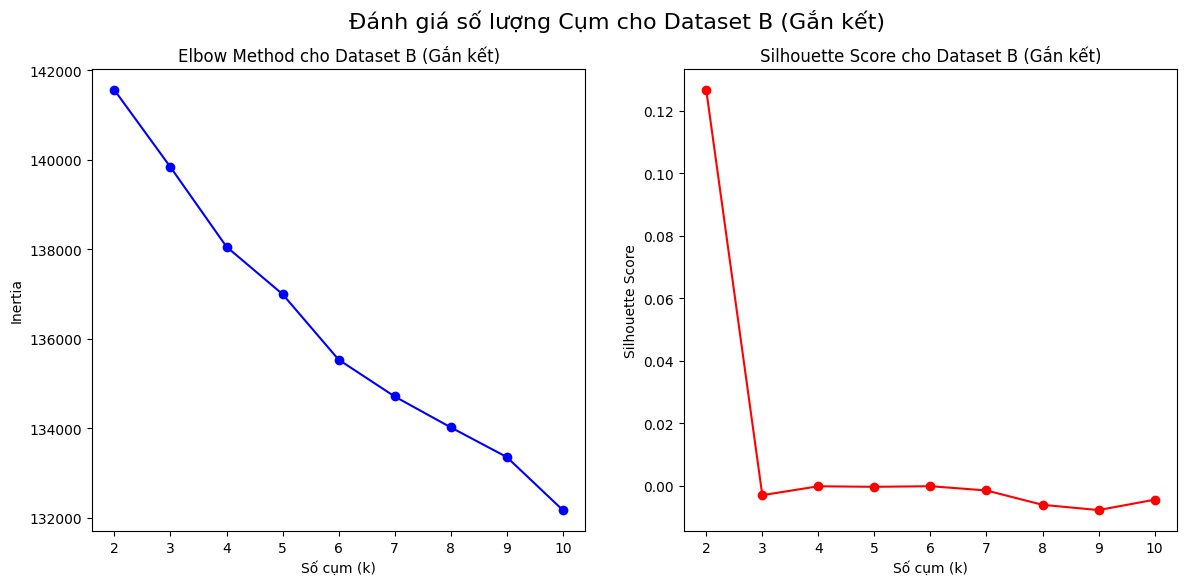

==> Dựa trên Silhouette Score, số cụm tối ưu cho Dataset B (Gắn kết) là: k = 2


In [48]:
# ==============================================================================
# CELL 4: CHUẨN HÓA DỮ LIỆU & TÌM SỐ CỤM TỐI ƯU (k)
# ==============================================================================

# --- Tách và chuẩn hóa dữ liệu tâm lý ---
# Dataset A
psychological_cols_a = data_a.columns[4:]
data_a_psych = data_a[psychological_cols_a]
scaler_a = StandardScaler()
data_a_scaled = scaler_a.fit_transform(data_a_psych)

# Dataset B
psychological_cols_b = data_b.columns[12:]
data_b_psych = data_b[psychological_cols_b]
scaler_b = StandardScaler()
data_b_scaled = scaler_b.fit_transform(data_b_psych)

print("✅ Dữ liệu tâm lý đã được tách và chuẩn hóa.")

# --- Hàm tìm k tối ưu ---
def find_optimal_clusters(data_scaled, dataset_name):
    k_range = range(2, 11)
    inertia_values = []
    silhouette_scores = []
    print(f"\n--- Đang tìm số cụm tối ưu cho {dataset_name} ---")
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(data_scaled)
        inertia_values.append(kmeans.inertia_)
        score = silhouette_score(data_scaled, kmeans.labels_)
        silhouette_scores.append(score)
        print(f"Với k={k}, Silhouette Score là: {score:.4f}")

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(k_range, inertia_values, 'bo-')
    plt.xlabel('Số cụm (k)'); plt.ylabel('Inertia'); plt.title(f'Elbow Method cho {dataset_name}')
    plt.subplot(1, 2, 2)
    plt.plot(k_range, silhouette_scores, 'ro-')
    plt.xlabel('Số cụm (k)'); plt.ylabel('Silhouette Score'); plt.title(f'Silhouette Score cho {dataset_name}')
    plt.suptitle(f'Đánh giá số lượng Cụm cho {dataset_name}', fontsize=16)
    plt.show()

    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"==> Dựa trên Silhouette Score, số cụm tối ưu cho {dataset_name} là: k = {optimal_k}")
    return optimal_k

# --- Chạy phân tích để tìm k tối ưu ---
optimal_k_a = find_optimal_clusters(data_a_scaled, "Dataset A (Động lực)")
optimal_k_b = find_optimal_clusters(data_b_scaled, "Dataset B (Gắn kết)")

In [49]:
# ==============================================================================
# CELL 5: HUẤN LUYỆN MÔ HÌNH CUỐI CÙNG & LƯU FILE
# ==============================================================================
import joblib
from sklearn.cluster import KMeans

# Chỉ chạy nếu các biến cần thiết đã tồn tại
if 'optimal_k_a' in globals() and 'optimal_k_b' in globals():
    # --- Huấn luyện mô hình K-Means cho Dataset A với k tối ưu ---
    print(f"\nĐang huấn luyện lại mô hình cho Dataset A với k = {optimal_k_a}...")
    kmeans_a = KMeans(n_clusters=optimal_k_a, random_state=42, n_init='auto')
    kmeans_a.fit(data_a_scaled)
    print("✅ Huấn luyện mô hình cho Dataset A thành công.")

    # --- Huấn luyện mô hình K-Means cho Dataset B với k tối ưu ---
    print(f"Đang huấn luyện lại mô hình cho Dataset B với k = {optimal_k_b}...")
    kmeans_b = KMeans(n_clusters=optimal_k_b, random_state=42, n_init='auto')
    kmeans_b.fit(data_b_scaled)
    print("✅ Huấn luyện mô hình cho Dataset B thành công.")

    # --- Lưu các mô hình và scaler đã huấn luyện ra file ---
    # Scaler cũng cần được lưu để có thể chuẩn hóa dữ liệu mới بنفس cách
    joblib.dump(kmeans_a, 'model_a_motivation.joblib')
    joblib.dump(scaler_a, 'scaler_a_motivation.joblib')
    joblib.dump(kmeans_b, 'model_b_engagement.joblib')
    joblib.dump(scaler_b, 'scaler_b_engagement.joblib')

    print("\n💾 Đã lưu thành công 4 files: 2 model và 2 scaler.")
    print("   Các file này sẽ được sử dụng trong notebook chính của dự án.")
else:
    print("⚠️ Lỗi: Không tìm thấy số cụm tối ưu. Vui lòng chạy lại CELL 4.")


Đang huấn luyện lại mô hình cho Dataset A với k = 2...
✅ Huấn luyện mô hình cho Dataset A thành công.
Đang huấn luyện lại mô hình cho Dataset B với k = 2...
✅ Huấn luyện mô hình cho Dataset B thành công.

💾 Đã lưu thành công 4 files: 2 model và 2 scaler.
   Các file này sẽ được sử dụng trong notebook chính của dự án.


In [50]:
# ==============================================================================
# CELL 6: PHÂN TÍCH VÀ DIỄN GIẢI KẾT QUẢ PHÂN CỤM
# ==============================================================================

# Chỉ chạy nếu các mô hình đã được huấn luyện
if 'kmeans_a' in globals() and 'kmeans_b' in globals():
    # Gán nhãn cụm cho từng học sinh vào DataFrame gốc để phân tích
    data_a['motivation_cluster'] = kmeans_a.labels_
    data_b['engagement_cluster'] = kmeans_b.labels_

    # --- Phân tích Dataset A (Động lực) ---
    print("="*50)
    print("--- Phân tích Cụm Động lực (Dataset A) ---")
    print("="*50)
    # .T để chuyển vị, giúp bảng dễ đọc hơn (mỗi cụm một cột)
    cluster_analysis_a = data_a.groupby('motivation_cluster')[psychological_cols_a].mean().T
    
    # Hiển thị toàn bộ các hàng để không bị cắt ngắn
    with pd.option_context('display.max_rows', None):
        display(cluster_analysis_a)
    
    print("\n Gợi ý diễn giải cho Dataset A:")
    print("   - So sánh các giá trị trung bình của Cluster 0 và Cluster 1.")
    print("   - Chú ý đến các nhóm câu hỏi có tiền tố 'PERF_LEV' (Chủ nghĩa hoàn hảo) và 'INTRINS' (Động lực nội tại).")
    print("   - Cụm nào có điểm 'PERF_LEV' cao hơn? Cụm nào có điểm 'INTRINS' cao hơn?")
    print("   - Dựa vào đó, hãy đặt tên cho Cluster 0 và Cluster 1 (ví dụ: 'Nhóm Lo âu Cầu toàn' vs 'Nhóm Tự tin Khám phá').")


    # --- Phân tích Dataset B (Gắn kết) ---
    print("\n" + "="*50)
    print("--- Phân tích Cụm Gắn kết (Dataset B) ---")
    print("="*50)
    cluster_analysis_b = data_b.groupby('engagement_cluster')[psychological_cols_b].mean().T

    with pd.option_context('display.max_rows', None):
        display(cluster_analysis_b)
        
    print("\n Gợi ý diễn giải cho Dataset B:")
    print("   - So sánh các giá trị trung bình của Cluster 0 và Cluster 1.")
    print("   - Chú ý đến các nhóm câu hỏi có tiền tố 'al_' (Sự xa lánh), 'par_' (Phụ huynh), và 'teach_' (Giáo viên).")
    print("   - Cụm nào có điểm 'al_' cao hơn? Cụm nào cảm nhận được sự quan tâm ('_pos_reg') từ cha mẹ/thầy cô nhiều hơn?")
    print("   - Dựa vào đó, hãy đặt tên cho Cluster 0 và Cluster 1 (ví dụ: 'Nhóm Gắn kết Tích cực' vs 'Nhóm Cảm thấy Lạc lõng').")

else:
    print("⚠️ Lỗi: Mô hình chưa được huấn luyện. Vui lòng chạy lại CELL 5.")

--- Phân tích Cụm Động lực (Dataset A) ---


motivation_cluster,0,1
FRE_ACT_Mental_Health,2.335393,2.029126
FRE_ACT_Physical_Health,3.597857,2.737864
FRE_ACT_Environment,3.177173,2.813592
FRE_ACT_Education,2.613515,2.341748
FRE_ACT_Gender_Equity,2.368356,2.442718
FRE_ACT_Poverty_Eradication,3.274413,2.126214
FRE_ACT_Peace_Justice,3.629584,2.623301
PERF_LEV_EC1,3.631232,2.091262
PERF_LEV_EC1,3.841780,1.848544
PERF_LEV_EC1,3.631232,2.091262



 Gợi ý diễn giải cho Dataset A:
   - So sánh các giá trị trung bình của Cluster 0 và Cluster 1.
   - Chú ý đến các nhóm câu hỏi có tiền tố 'PERF_LEV' (Chủ nghĩa hoàn hảo) và 'INTRINS' (Động lực nội tại).
   - Cụm nào có điểm 'PERF_LEV' cao hơn? Cụm nào có điểm 'INTRINS' cao hơn?
   - Dựa vào đó, hãy đặt tên cho Cluster 0 và Cluster 1 (ví dụ: 'Nhóm Lo âu Cầu toàn' vs 'Nhóm Tự tin Khám phá').

--- Phân tích Cụm Gắn kết (Dataset B) ---


engagement_cluster,0,1
nan_par_neg_reg,3.748078,3.754941
nan_par_hard_appr,4.017639,4.383399
nan_par_exam_acpt,4.021710,3.960474
nan_par_achv_care,3.862958,4.039526
nan_par_well_love,4.037540,3.591568
nan_par_achv_warm,4.085482,3.313570
nan_par_pos_reg,3.993668,3.891963
nan_par_lazy_appr_neg,4.036635,3.861660
nan_par_exam_acpt_neg,4.048394,3.935441
nan_par_achv_care_neg,4.168250,3.573123



 Gợi ý diễn giải cho Dataset B:
   - So sánh các giá trị trung bình của Cluster 0 và Cluster 1.
   - Chú ý đến các nhóm câu hỏi có tiền tố 'al_' (Sự xa lánh), 'par_' (Phụ huynh), và 'teach_' (Giáo viên).
   - Cụm nào có điểm 'al_' cao hơn? Cụm nào cảm nhận được sự quan tâm ('_pos_reg') từ cha mẹ/thầy cô nhiều hơn?
   - Dựa vào đó, hãy đặt tên cho Cluster 0 và Cluster 1 (ví dụ: 'Nhóm Gắn kết Tích cực' vs 'Nhóm Cảm thấy Lạc lõng').


In [51]:
print("\n--- Phân bổ học sinh theo Cụm Động lực (Dataset A) ---")
print(data_a['motivation_cluster'].value_counts())

print("\n--- Phân bổ học sinh theo Cụm Gắn kết (Dataset B) ---")
print(data_b['engagement_cluster'].value_counts())


--- Phân bổ học sinh theo Cụm Động lực (Dataset A) ---
motivation_cluster
0    2427
1     515
Name: count, dtype: int64

--- Phân bổ học sinh theo Cụm Gắn kết (Dataset B) ---
engagement_cluster
0    2211
1     759
Name: count, dtype: int64
